# Coursera Capstone Project – An analysis of the entertainment and food venues in London

## Introduction and Business Problem

London is second most visited city around the world in 2018. 

Very often, visitors to London spend their time in west London and not in the other parts of London. I would like to use the data available in Foursquare to find the most popular venues (restaurants, shopping areas, museums, cafes etc) throughout London.

I will also like to cluster the neighbourhoods of London, to find out if there are neighbourhoods similar to the popular western part of London.

This will show us if popular venues can be found in other parts of London, and if there are other parts of London worth visiting.

We will be performing the clustering based on (1) the **Number of Venues** in each neighbourhood, (2) the **Venue Ratings** and (3) **Likes Received** by each venue. We will be using the **k-means clustering** algorithm.

We will also be using the Folium library to visualize the neighborhood clusters in the London.

## Description of data

### Data Sources

1. The postcodes of the neighbourhoods in London can be found here.
city (https://www.doogal.co.uk/london_postcodes.php)
greater london (https://www.doogal.co.uk/Counties.php?county=E11000009)

2. Geocoder will be used to find the latitudes and longitudes of the postcodes of each neighbourhood.

3. Foursquare's **explore** function will be used to find venues within a certain distance of the latitudes and longitudes of each neighbourhood.

4. Foursquare's **Get Details of a Venue** function will be used to find more information on the venues. Specifically, I will be using the Venue Ratings and Number of Likes received by the venue.

3. I will be providing a mapping to Foursquare's categorisation of venues to simplify the categorisation.

### Data Cleaning

1. Neighbourhood postcode

Postcodes not longer in used and duplicates are excluded.

The postcode is simplified to cut down on the number of postcodes, this is to prevent Foursquare from returning the same venues for overlapping postcodes.

2. Venue Categorisation

I simplified the categorization of venues as provided by Foursquare as an initial analysis showed that many neighbourhoods were being clustered in a small number of clusters if too many venue categories are used.

3. Neighbourhood and venue details

The Venue Ratings and Likes Received by each venue, were normalized using the max-min method.

The Number of Venues in each neighbourhood was normalized using the mean method.


## Methodology

### Exploratory Data Analysis

Correlation analysis is performed on the initial set of features to check if there is high levels of correlation between any features. If correlation above 0.9 is found between 2 features, one of them will be removed.


### Feature Selection

Correlation analysis is performed on the initial set of features to check if there is high levels of correlation between any features. If correlation above 0.9 is found between 2 features, one of them will be removed. Please refer to the Correlation analysis below.

### Cluster Algorithm

CLustering will be performed using the k-means clustering method on the selected features.

## Results, Discussions & Recommendations

# Codes

## Download of all packages required

In [1]:
# Install geopy
!pip install geopy

import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

# import Beautiful Soup
from urllib.parse import urljoin
from urllib.parse import urlparse
from urllib.request import urlopen

# import Seaborn
import seaborn as sns

# import Geocoder
!pip install geocoder
import geocoder

# import Beautiful Soup
!pip install beautifulsoup4
from bs4 import BeautifulSoup

# import lxml
!pip install lxml

# import datetime
from datetime import date
import datetime

print('Libraries imported.')

     |████████████████████████████████| 102kB 2.9MB/s ta 0:00:011
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/99/45/d1/14954797e2a976083182c2e7da9b4e924509e59b6e5c661061
Successfully built geographiclib
     |████████████████████████████████| 102kB 2.9MB/s ta 0:00:011
     |████████████████████████████████| 829kB 24.7MB/s eta 0:00:01
     |████████████████████████████████| 81kB 14.5MB/s eta 0:00:01
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/0c/61/d2/d6b7317325828fbb39ee6ad559dbe4664d0896da4721bf379e
Successfully built future
     |████████████████████████████████| 102kB 2.9MB/s ta 0:00:011
     |████████████████████████████████| 5.8MB 3.0MB/s eta 0:00:01
Libraries imported.


<a id='item1'></a>

# Data Sources and Cleaning

## 1. Download and Explore Dataset

### Read the city of london csv file and convert into a panda dataframe

The City of London postcodes have been downloaded from
https://www.doogal.co.uk/london_postcodes.php

In [2]:
df = pd.read_csv("londonpostcodes.csv", delimiter=",")
print('Shape: ', df.shape)
df.head(3)

Shape:  (6800, 16)


,Postcode,In Use?,Latitude,Longitude,Easting,Northing,Grid Ref,Ward,Parish,Introduced,Terminated,Altitude,Country,Last Updated,Quality,LSOA Code
0,E1 6AN,Yes,51.518895,-0.078378,533425,181747,TQ334817,Bishopsgate,"City of London, unparished area",1980-01-01,NaN,32,England,2019-05-29,Within the building of the matched address clo...,E01032739
1,E1 7AA,Yes,51.515567,-0.075635,533625,181382,TQ336813,Portsoken,"City of London, unparished area",2000-12-01,NaN,28,England,2019-05-29,Within the building of the matched address clo...,E01000005
2,E1 7AD,Yes,51.515457,-0.076718,533550,181368,TQ335813,Portsoken,"City of London, unparished area",2013-09-01,NaN,31,England,2019-05-29,Within the building of the matched address clo...,E01000005


Drop some columns and rename the columns

In [3]:
new=df["Postcode"].str.split(" ", n = 1, expand = True)
df1=df
df1["wPostcode"] = new[0]
df1["uwPostcode"] = new[1]
df1 = df.filter(['wPostcode','In Use?','Ward','Parish'], axis=1)
df1.columns = ['Postcode','In_use','Neighborhood','Parish']
print('Shape: ', df1.shape)
df1.head(3)

Shape:  (6800, 4)


,Postcode,In_use,Neighborhood,Parish
0,E1,Yes,Bishopsgate,"City of London, unparished area"
1,E1,Yes,Portsoken,"City of London, unparished area"
2,E1,Yes,Portsoken,"City of London, unparished area"


The Greater London postcodes have been downloaded from
https://www.doogal.co.uk/Counties.php?county=E11000009

### Read the greater london csv file and convert into a panda dataframe

In [4]:
outdf = pd.read_csv("greaterlondonpostcodes.csv", delimiter=",")
print('Shape: ', outdf.shape)
#outdf.head(2)

Shape:  (313626, 16)


In [5]:
newout=outdf["Postcode"].str.split(" ", n = 1, expand = True)
outdf1=outdf
outdf1["wPostcode"] = newout[0]
outdf1["uwPostcode"] = newout[1]
outdf1 = outdf.filter(['wPostcode','In Use?','Built Up Area Sub-Division','Built Up Area'], axis=1)
outdf1.columns = ['Postcode','In_use','Neighborhood','Parish']
print('Shape: ', outdf1.shape)
outdf1.head(2)

Shape:  (313626, 4)


,Postcode,In_use,Neighborhood,Parish
0,BR1,Yes,Bromley,Greater London
1,BR1,Yes,Bromley,Greater London


### Wrangle with the City of London data

Remove city of london postcodes which are no longer in use

In [6]:
df2=df1[df1.In_use != 'No']
print('Shape: ', df2.shape)
df2.head(2)

Shape:  (1730, 4)


,Postcode,In_use,Neighborhood,Parish
0,E1,Yes,Bishopsgate,"City of London, unparished area"
1,E1,Yes,Portsoken,"City of London, unparished area"


Drop duplicate rows

In [7]:
df3=df2.drop_duplicates()
print('Shape: ', df3.shape)
df3.head(2)

Shape:  (96, 4)


,Postcode,In_use,Neighborhood,Parish
0,E1,Yes,Bishopsgate,"City of London, unparished area"
1,E1,Yes,Portsoken,"City of London, unparished area"


Group neighborhoods by postcode

In [8]:
df4=df3.groupby(['Postcode','In_use','Parish'], sort = False).agg(lambda x: ','.join(x))
df4.reset_index(level=['Postcode','In_use','Parish'], inplace=True)
print('Shape: ', df4.shape)
df4.head(2)

Shape:  (26, 4)


,Postcode,In_use,Parish,Neighborhood
0,E1,Yes,"City of London, unparished area","Bishopsgate,Portsoken,Aldgate,Tower"
1,EC1A,Yes,"City of London, unparished area","Farringdon Within,Farringdon Without,Cheap,Ald..."


### Wrangle with the Greater London data

Remove greater london postcodes which are no longer in use

In [9]:
outdf2=outdf1[outdf1.In_use != 'No']
print('Shape: ', outdf2.shape)
outdf2.head(2)

Shape:  (176237, 4)


,Postcode,In_use,Neighborhood,Parish
0,BR1,Yes,Bromley,Greater London
1,BR1,Yes,Bromley,Greater London


Drop duplicate rows

In [10]:
outdf3=outdf2.drop_duplicates()
print('Shape: ', outdf3.shape)
outdf3.head(2)

Shape:  (682, 4)


,Postcode,In_use,Neighborhood,Parish
0,BR1,Yes,Bromley,Greater London
1091,BR1,Yes,Lewisham,Greater London


Drop rows with blanks

In [11]:
outdf4=outdf3.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
print('Shape: ', outdf4.shape)
outdf4.head(2)

Shape:  (541, 4)


,Postcode,In_use,Neighborhood,Parish
0,BR1,Yes,Bromley,Greater London
1091,BR1,Yes,Lewisham,Greater London


Group neighborhoods by postcode

In [12]:
outdf5=outdf4.groupby(['Postcode','In_use','Parish'], sort = False).agg(lambda x: ','.join(x))
outdf5.reset_index(level=['Postcode','In_use','Parish'], inplace=True)
print('Shape: ', outdf5.shape)
outdf5.head(2)

Shape:  (303, 4)


,Postcode,In_use,Parish,Neighborhood
0,BR1,Yes,Greater London,"Bromley,Lewisham"
1,BR2,Yes,Greater London,Bromley


### Concatenating the City of London and Greater London data

In [13]:
gldf=pd.concat([df4,outdf5], axis=0, sort=False)
gldf.reset_index(inplace=True)
gldf=gldf.drop(['index'], axis =1)
print('Shape: ', gldf.shape)
gldf.head(2)

Shape:  (329, 4)


,Postcode,In_use,Parish,Neighborhood
0,E1,Yes,"City of London, unparished area","Bishopsgate,Portsoken,Aldgate,Tower"
1,EC1A,Yes,"City of London, unparished area","Farringdon Within,Farringdon Without,Cheap,Ald..."


Group neighborhoods by postcode

In [14]:
gldf2=gldf.groupby(['Postcode','In_use'], sort = False).agg(lambda x: ','.join(x))
gldf2.reset_index(level=['Postcode','In_use'], inplace=True)
print('Shape: ', gldf2.shape)
gldf2.head(2)

Shape:  (301, 4)


,Postcode,In_use,Parish,Neighborhood
0,E1,Yes,"City of London, unparished area,Greater London","Bishopsgate,Portsoken,Aldgate,Tower,Tower Haml..."
1,EC1A,Yes,"City of London, unparished area,Greater London","Farringdon Within,Farringdon Without,Cheap,Ald..."


## 2. Find Longitude and Latitude of the Post codes

In [15]:
long_start_time = datetime.datetime.now()
long_start_time_str = str(long_start_time)
start_time = long_start_time_str[:-3]
print('Start time:', start_time)

Lat_list=[]
Lng_list=[]
#n=0
for i in range(gldf2.shape[0]):
    address='{}'.format(gldf2.at[i,'Postcode'])
#'for i in range({}.shape[0]):'.format(datasource)
#    'address='{}'.format({}.at[i,'Postcode'])'.format(datasource)
#    n=n+1
#    print('count:', n)
#    print('address:', address)
    g = geocoder.arcgis(address)
    Lat_list.append(g.latlng[0])
    Lng_list.append(g.latlng[1])

long_end_time = datetime.datetime.now()
long_end_time_str = str(long_end_time)
end_time = long_end_time_str[:-3]
print('End time', end_time)
time_taken = 0
time_taken = (long_end_time - long_start_time)
print('Run time', time_taken) 

Start time: 2019-08-29 22:07:44.069
End time 2019-08-29 22:10:33.316
Run time 0:02:49.246557


In [16]:
dflat = pd.DataFrame(Lat_list, columns=["Latitude"])
dflng = pd.DataFrame(Lng_list, columns=["Longitude"])
london_data=pd.concat([gldf2,dflat,dflng], axis=1, sort=False)
print('Shape: ', london_data.shape)
london_data.head(2)

Shape:  (301, 6)


,Postcode,In_use,Parish,Neighborhood,Latitude,Longitude
0,E1,Yes,"City of London, unparished area,Greater London","Bishopsgate,Portsoken,Aldgate,Tower,Tower Haml...",27.962040,86.933700
1,EC1A,Yes,"City of London, unparished area,Greater London","Farringdon Within,Farringdon Without,Cheap,Ald...",51.516355,-0.099135


Read the London data that i had earlier run and extracted, we don't need to repeat the wrangling process

In [17]:
london_datadf = pd.read_csv("london_data.csv", delimiter=",")
london_datadf1=london_datadf.drop(london_datadf.columns[0], axis=1)
print(london_datadf1.shape)
london_datadf1.head(2)

(301, 6)


,Postcode,In_use,Parish,Neighborhood,Latitude,Longitude
0,E1,Yes,"City of London, unparished area,Greater London","Bishopsgate,Portsoken,Aldgate,Tower,Tower Haml...",27.962040,86.933700
1,EC1A,Yes,"City of London, unparished area,Greater London","Farringdon Within,Farringdon Without,Cheap,Ald...",51.516355,-0.099135


### Use geopy library to get the latitude and longitude values of the City of London

In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent <em>citylondon_explorer</em>, as shown below.

In [18]:
address = 'City of London'

geolocator = Nominatim(user_agent="citylondon_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of the City of London are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of the City of London are 51.5156177, -0.0919983.


### Create a map of the City of London with neighborhoods superimposed on top.

In [19]:
# create map of London using latitude and longitude values
map_london = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, neighborhood, postcode in zip(london_datadf1['Latitude'], london_datadf1['Longitude'], london_datadf1['Neighborhood'], london_datadf1['Postcode']):
    label = '{} {}'.format(neighborhood, postcode)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london)  
    
map_london

**Folium** is a great visualization library. Feel free to zoom into the above map, and click on each circle mark to reveal the name of the neighborhood and its respective borough.

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

### Define Foursquare Credentials and Version

In [20]:
today = date.today()
today = today.strftime("%Y%m%d")

In [21]:
CLIENT_ID = 'xxx' # your Foursquare ID
CLIENT_SECRET = 'xxx' # your Foursquare Secret
VERSION = today # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: xxx
CLIENT_SECRET:xxx


<a id='item2'></a>

### 3. Use the Foursquare Explore function to find venues in each neighborhood in London

#### Use the latitude and longitude of the neighborhood to find a predetermined number of venues within a radius

#### Run the above function on each neighborhood and create a new dataframe called *london_venues*.

This is to load the venue latitude and longitude that I had previously extracted

In [22]:
london_venuesdf = pd.read_csv("london_venues.csv", delimiter=",")
london_venuesdf1=london_venuesdf.drop(london_venuesdf.columns[0], axis=1)
print(london_venuesdf1.shape)
london_venuesdf1.head(3)

(1913, 9)


,Neighborhood Postcode,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category
0,EC1A,"Farringdon Within,Farringdon Without,Cheap,Ald...",51.516355,-0.099135,4dff32bae4cdf7246077a9aa,Pilpel,51.515195,-0.098462,Falafel Restaurant
1,EC1A,"Farringdon Within,Farringdon Without,Cheap,Ald...",51.516355,-0.099135,4ad3be62f964a52012e620e3,Postman's Park,51.516860,-0.097643,Park
2,EC1A,"Farringdon Within,Farringdon Without,Cheap,Ald...",51.516355,-0.099135,4c56b2a912f0d13a675605ad,Christ Church Greyfriars Garden,51.515670,-0.098760,Garden


I have provided a higher level categorisation of the venues so that we can compare the venues

In [23]:
category_mapdf = pd.read_csv("highlevelcategory.csv", delimiter=",")
print(category_mapdf.shape)
category_mapdf.head(3)

(245, 2)


,Venue Category,Highcategory
0,Accessories Store,Shopping
1,African Restaurant,Food
2,Airport,Transport


### 4. Merging the higher category into the venues

In [24]:
london_venues_merged=pd.merge(london_venuesdf1,category_mapdf, on='Venue Category')
print(london_venues_merged.shape)
london_venues_merged.head(3)

(1913, 10)


,Neighborhood Postcode,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category,Highcategory
0,EC1A,"Farringdon Within,Farringdon Without,Cheap,Ald...",51.516355,-0.099135,4dff32bae4cdf7246077a9aa,Pilpel,51.515195,-0.098462,Falafel Restaurant,Food
1,EC1N,"Castle Baynard,Farringdon Without,Camden,Islin...",51.520029,-0.110511,5763e197498ea21c06599a13,Dukan 41,51.519211,-0.109040,Falafel Restaurant,Food
2,EC3V,"Langbourn,Bridge,Candlewick,Cornhill,Lime Stre...",51.511420,-0.085105,5a3919c93b4e007db77240d9,Pilpel,51.512326,-0.084085,Falafel Restaurant,Food


#### Let's check the size of the resulting dataframe

In [25]:
print(london_venues_merged.shape)
london_venues_merged.head(3)

(1913, 10)


,Neighborhood Postcode,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category,Highcategory
0,EC1A,"Farringdon Within,Farringdon Without,Cheap,Ald...",51.516355,-0.099135,4dff32bae4cdf7246077a9aa,Pilpel,51.515195,-0.098462,Falafel Restaurant,Food
1,EC1N,"Castle Baynard,Farringdon Without,Camden,Islin...",51.520029,-0.110511,5763e197498ea21c06599a13,Dukan 41,51.519211,-0.109040,Falafel Restaurant,Food
2,EC3V,"Langbourn,Bridge,Candlewick,Cornhill,Lime Stre...",51.511420,-0.085105,5a3919c93b4e007db77240d9,Pilpel,51.512326,-0.084085,Falafel Restaurant,Food


In [26]:
print('There are {} uniques venues.'.format(len(london_venuesdf1['Venue'].unique())))

There are 1496 uniques venues.


### 5. Use the Foursquare "Get Details of a Venue" function to find details for each venue

##### Gather unique set of Venue IDs

### This is to load the venue details that I had previously extracted

In [27]:
# Loading the venue details that I have already extracted
london_venuedetails_part1df = pd.read_csv("london_venuedetails_part1.csv", delimiter=",")
london_venuedetails_part2df = pd.read_csv("london_venuedetails_part2.csv", delimiter=",")
london_venuedetails_part3df = pd.read_csv("london_venuedetails_part3.csv", delimiter=",")
london_venuedetails_part4df = pd.read_csv("london_venuedetails_part4.csv", delimiter=",")
london_venuedetails_part5df = pd.read_csv("london_venuedetails_part5.csv", delimiter=",")
london_venuedetailsdf=pd.concat([london_venuedetails_part1df,london_venuedetails_part2df,london_venuedetails_part3df,london_venuedetails_part4df], axis=0, sort=False)

london_venuedetailsdf=london_venuedetailsdf.drop(london_venuedetailsdf.columns[0], axis=1)
print(london_venuedetailsdf.shape)
london_venuedetailsdf.head(3)

(5066, 6)


,venueID,venueRating,listedCount,photosCount,likesCount,tipsCount
0,4dff32bae4cdf7246077a9aa,9.1,201.0,25.0,129.0,34.0
1,4ad3be62f964a52012e620e3,8.6,123.0,179.0,79.0,23.0
2,4c56b2a912f0d13a675605ad,8.5,18.0,79.0,22.0,3.0


# Methodology

## Exploratory Data Analysis

### 1. We are exploring the number of venues in each neighbourhood.

In [28]:
num_venues_london=london_venues_merged[['Neighborhood','Venue']]
num_venues_london = num_venues_london.groupby(['Neighborhood']).count().sort_values(by='Venue', axis=0, ascending=False)
#num_venues_london.reset_index(level=['Neighborhood'], inplace=True)
#um_venues_london=num_venues_london[['Neighborhood','Venue']]
print('Shape: ', num_venues_london.shape)
num_venues_london.head(2)

Shape:  (136, 1)


,Venue
Neighborhood,
"City of Westminster,Islington",154
"Camden,Islington",90


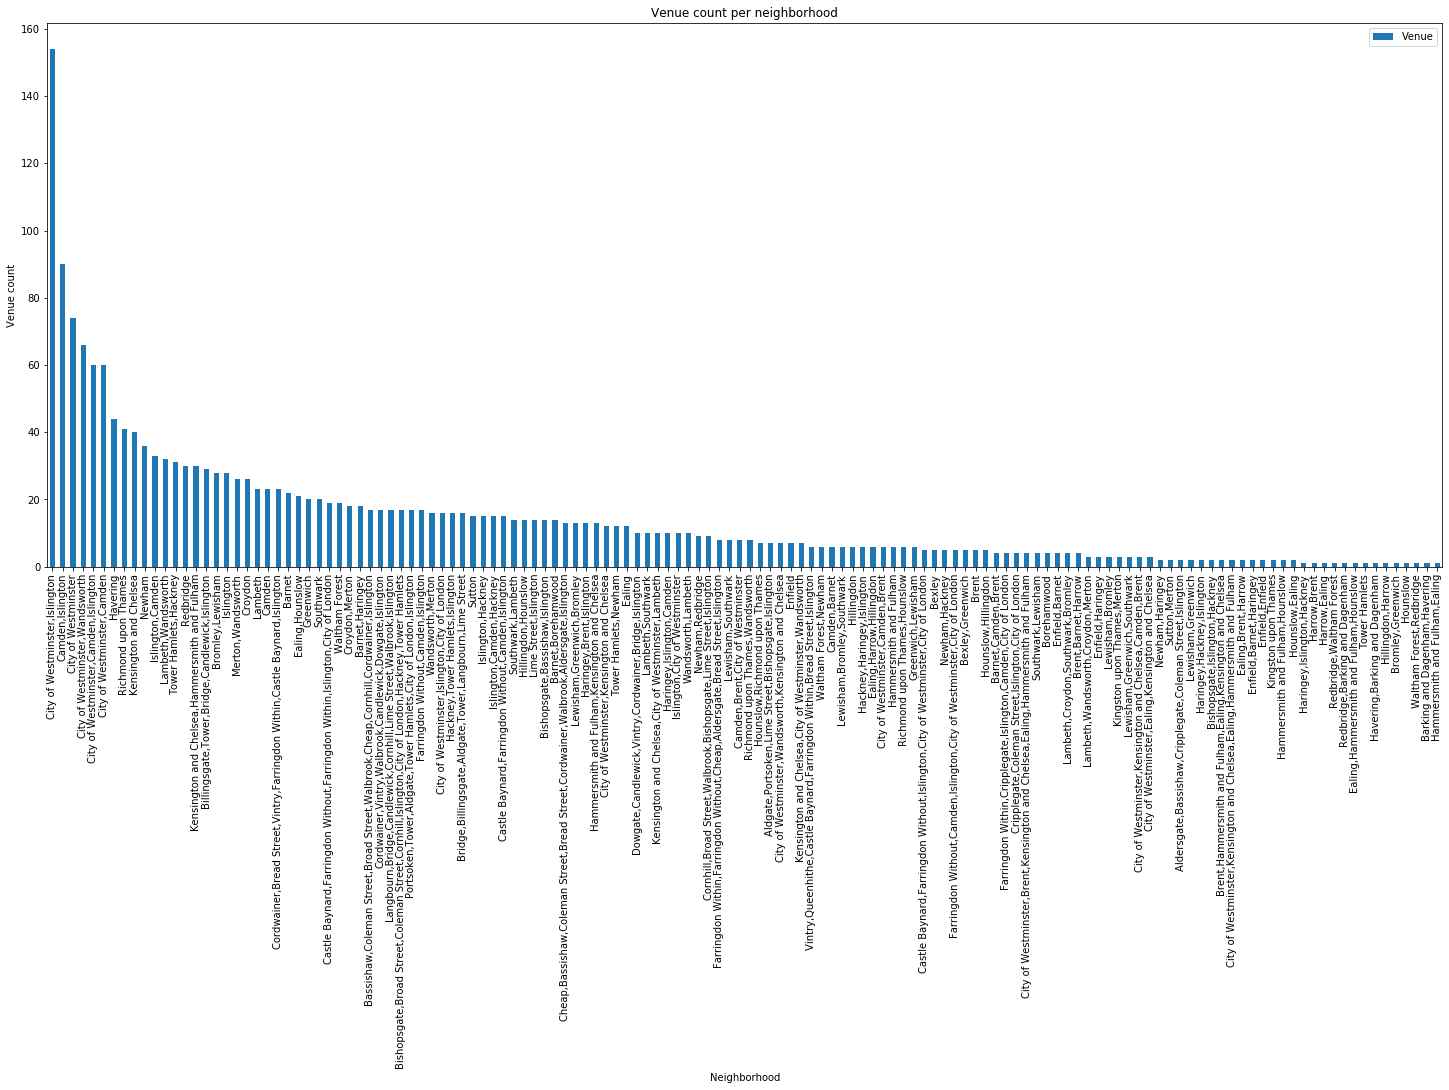

In [29]:
num_venues_london.plot(kind='bar', figsize=(25, 10))

plt.xlabel('Neighborhood') # add to x-label to the plot
plt.ylabel('Venue count') # add y-label to the plot
plt.title('Venue count per neighborhood') # add title to the plot

plt.show()

#### Findings: There is a big divergence in the number of venues in each neighborhood. More venues can generally be found in the neighbourhoods in west London.

### 2. We now explore the venue details.

#### Check if there are duplicate values in the venue details data. Remove duplicates if there are.

In [30]:
london_venuedetailsdf1=london_venuedetailsdf.drop_duplicates()
print('Shape: ', london_venuedetailsdf1.shape)
london_venuedetailsdf1.head(10)

Shape:  (2698, 6)


,venueID,venueRating,listedCount,photosCount,likesCount,tipsCount
0,4dff32bae4cdf7246077a9aa,9.1,201.0,25.0,129.0,34.0
1,4ad3be62f964a52012e620e3,8.6,123.0,179.0,79.0,23.0
2,4c56b2a912f0d13a675605ad,8.5,18.0,79.0,22.0,3.0
3,51e68bd2498eca96aefe97fe,7.4,1.0,6.0,10.0,1.0
4,4b61ca0ef964a520f2222ae3,6.2,6.0,78.0,54.0,13.0
5,4bc41075b492d13a8b9fa960,6.1,1.0,33.0,9.0,3.0
6,4c5bf5e62815c92830a2b067,5.9,0.0,0.0,2.0,1.0
7,4b4ef055f964a5205ff726e3,5.8,1.0,1.0,20.0,11.0
8,53481e2811d2956b80ff5896,8.4,108.0,67.0,118.0,22.0
9,4c5936cef346c928cffd4bca,7.2,4.0,1.0,5.0,7.0


#### Check if there are NaN values in the venue details data

In [31]:
london_venuedetailsdf1.isnull().any().any()

True

In [32]:
london_venuedetailsdf2=london_venuedetailsdf1.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
london_venuedetailsdf2['totalCount']=london_venuedetailsdf2['listedCount']+london_venuedetailsdf2['photosCount']+london_venuedetailsdf2['likesCount']+london_venuedetailsdf2['tipsCount']
london_venuedetailsdf2=london_venuedetailsdf2.reset_index(drop=True)
london_venuedetailsdf2.columns = ['Venue ID','venueRating','listedCount','photosCount','likesCount','tipsCount','Total Likes']
print('Shape: ', london_venuedetailsdf2.shape)
london_venuedetailsdf2.head(5)

Shape:  (1066, 7)


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Venue ID,venueRating,listedCount,photosCount,likesCount,tipsCount,Total Likes
0,4dff32bae4cdf7246077a9aa,9.1,201.0,25.0,129.0,34.0,389.0
1,4ad3be62f964a52012e620e3,8.6,123.0,179.0,79.0,23.0,404.0
2,4c56b2a912f0d13a675605ad,8.5,18.0,79.0,22.0,3.0,122.0
3,51e68bd2498eca96aefe97fe,7.4,1.0,6.0,10.0,1.0,18.0
4,4b61ca0ef964a520f2222ae3,6.2,6.0,78.0,54.0,13.0,151.0


#### Check the distribution of the Ratings and Likes

In [33]:
print('Maximum Rating value: ', london_venuedetailsdf2["venueRating"].max())
print('Minimum Rating value: ', london_venuedetailsdf2["venueRating"].min())

Maximum Rating value:  9.5
Minimum Rating value:  5.4


In [34]:
print('Maximum Likes value: ', london_venuedetailsdf2["Total Likes"].max())
print('Minimum Likes value: ', london_venuedetailsdf2["Total Likes"].min())

Maximum Likes value:  11401.0
Minimum Likes value:  0.0


#### We can see that the ratings range from 0 to 10, and the likes can be as high as a 11 thousand, hence we need to normalize them before using them in the clustering algorithm

?? We also drop rows with blanks

In [35]:
london_venuedetailsdf2['Normalized Likes'] = (london_venuedetailsdf2['Total Likes']-london_venuedetailsdf2['Total Likes'].min())/(london_venuedetailsdf2['Total Likes'].max()-london_venuedetailsdf2['Total Likes'].min())
london_venuedetailsdf2['Normalized Ratings'] = (london_venuedetailsdf2['venueRating']-london_venuedetailsdf2['venueRating'].min())/(london_venuedetailsdf2['venueRating'].max()-london_venuedetailsdf2['venueRating'].min())
london_venuedetailsdf2.head(5)

,Venue ID,venueRating,listedCount,photosCount,likesCount,tipsCount,Total Likes,Normalized Likes,Normalized Ratings
0,4dff32bae4cdf7246077a9aa,9.1,201.0,25.0,129.0,34.0,389.0,0.034120,0.902439
1,4ad3be62f964a52012e620e3,8.6,123.0,179.0,79.0,23.0,404.0,0.035435,0.780488
2,4c56b2a912f0d13a675605ad,8.5,18.0,79.0,22.0,3.0,122.0,0.010701,0.756098
3,51e68bd2498eca96aefe97fe,7.4,1.0,6.0,10.0,1.0,18.0,0.001579,0.487805
4,4b61ca0ef964a520f2222ae3,6.2,6.0,78.0,54.0,13.0,151.0,0.013244,0.195122


### 3. Merging the Counts and Ratings into the Venues to create a consolidated table

In [36]:
# Merged Neighborhood details with venue details
london_venues_merged_data=pd.merge(london_venues_merged,london_venuedetailsdf2, on='Venue ID')
print(london_venues_merged_data.shape)
london_venues_merged_data.head(3)

(1158, 18)


,Neighborhood Postcode,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category,Highcategory,venueRating,listedCount,photosCount,likesCount,tipsCount,Total Likes,Normalized Likes,Normalized Ratings
0,EC1A,"Farringdon Within,Farringdon Without,Cheap,Ald...",51.516355,-0.099135,4dff32bae4cdf7246077a9aa,Pilpel,51.515195,-0.098462,Falafel Restaurant,Food,9.1,201.0,25.0,129.0,34.0,389.0,0.034120,0.902439
1,EC1N,"Castle Baynard,Farringdon Without,Camden,Islin...",51.520029,-0.110511,5763e197498ea21c06599a13,Dukan 41,51.519211,-0.109040,Falafel Restaurant,Food,8.8,7.0,1.0,18.0,5.0,31.0,0.002719,0.829268
2,EC3V,"Langbourn,Bridge,Candlewick,Cornhill,Lime Stre...",51.511420,-0.085105,5a3919c93b4e007db77240d9,Pilpel,51.512326,-0.084085,Falafel Restaurant,Food,8.1,6.0,1.0,7.0,4.0,18.0,0.001579,0.658537


In [37]:
#path='london_venues_merged_data.csv'
#london_venues_merged_data.to_csv(path)

In [38]:
london_venues_merged_data = pd.read_csv("london_venues_merged_data.csv", delimiter=",")
london_venues_merged_data=london_venues_merged_data.drop(london_venues_merged_data.columns[0], axis=1)
print(london_venues_merged_data.shape)
london_venues_merged_data.head(3)

(1158, 18)


,Neighborhood Postcode,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category,Highcategory,venueRating,listedCount,photosCount,likesCount,tipsCount,Total Likes,Normalized Likes,Normalized Ratings
0,EC1A,"Farringdon Within,Farringdon Without,Cheap,Ald...",51.516355,-0.099135,4dff32bae4cdf7246077a9aa,Pilpel,51.515195,-0.098462,Falafel Restaurant,Food,9.1,201.0,25.0,129.0,34.0,389.0,0.034120,0.902439
1,EC1N,"Castle Baynard,Farringdon Without,Camden,Islin...",51.520029,-0.110511,5763e197498ea21c06599a13,Dukan 41,51.519211,-0.109040,Falafel Restaurant,Food,8.8,7.0,1.0,18.0,5.0,31.0,0.002719,0.829268
2,EC3V,"Langbourn,Bridge,Candlewick,Cornhill,Lime Stre...",51.511420,-0.085105,5a3919c93b4e007db77240d9,Pilpel,51.512326,-0.084085,Falafel Restaurant,Food,8.1,6.0,1.0,7.0,4.0,18.0,0.001579,0.658537


### 4. Visualize the venue locations for all Venue categories

In [39]:
# create map of London using latitude and longitude values
map_londonvenues = folium.Map(location=[latitude, longitude], zoom_start=11)

vn = folium.map.FeatureGroup()

# Add the venues to the map
for lat, lng, in zip(london_venues_merged_data['Venue Latitude'], london_venues_merged_data['Venue Longitude']):
    vn.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=3, # define how big you want the circle markers to be
#            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )    
    
# add venues to map
map_londonvenues.add_child(vn)

### 5. Visualize the venue locations for the category of Fun

In [40]:
# create map of London fun venues using latitude and longitude values
londonfun=london_venues_merged_data[london_venues_merged_data['Highcategory'] == 'Shopping']

map_londonfunvenues = folium.Map(location=[latitude, longitude], zoom_start=13)

vn = folium.map.FeatureGroup()

# Add the venues to the map
for lat, lng, in zip(londonfun['Venue Latitude'], londonfun['Venue Longitude']):
    vn.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=3, # define how big you want the circle markers to be
#            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )    
    
# add venues to map
map_londonfunvenues.add_child(vn)

### 6. Visualize the venue location for the category of Nightlife

In [41]:
# create map of London fun venues using latitude and longitude values
londonnight=london_venues_merged_data[london_venues_merged_data['Highcategory'] == 'Nightlife']

map_londonnightvenues = folium.Map(location=[latitude, longitude], zoom_start=13)

vn = folium.map.FeatureGroup()

# Add the venues to the map
for lat, lng, in zip(londonnight['Venue Latitude'], londonnight['Venue Longitude']):
    vn.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=3, # define how big you want the circle markers to be
#            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )    
    
# add venues to map
map_londonnightvenues.add_child(vn)

### 7. Visualize the venue location for the category of Food

In [42]:
# create map of London fun venues using latitude and longitude values
londonfood=london_venues_merged_data[london_venues_merged_data['Highcategory'] == 'Food']

map_londonfoodvenues = folium.Map(location=[latitude, longitude], zoom_start=13)

vn = folium.map.FeatureGroup()

# Add the venues to the map
for lat, lng, in zip(londonnight['Venue Latitude'], londonnight['Venue Longitude']):
    vn.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=3, # define how big you want the circle markers to be
#            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )    
    
# add venues to map
map_londonfoodvenues.add_child(vn)

### 8. Let's check how many venues have been returned for each neighborhood after duplicates and zero ratings/ likes have been removed.

In [43]:
london_venues_merged_data.groupby(['Neighborhood Postcode','Neighborhood']).count()

,,Neighborhood Latitude,Neighborhood Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category,Highcategory,venueRating,listedCount,photosCount,likesCount,tipsCount,Total Likes,Normalized Likes,Normalized Ratings
Neighborhood Postcode,Neighborhood,,,,,,,,,,,,,,,,
BR1,"Bromley,Lewisham",24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24
BR7,"Bromley,Greenwich",1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
CR2,Croydon,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16
CR44,Sutton,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
CR6,Croydon,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
CR7,"Croydon,Merton",16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16
E10,Waltham Forest,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
E12,"Newham,Redbridge",8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8
E13,Newham,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2


<a id='item3'></a>

### 9. Compute the number of venues (in terms of categories) for each neighbourhood

In [44]:
# one hot encoding
london_onehot = pd.get_dummies(london_venues_merged_data[['Highcategory']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
london_onehot['Neighborhood'] = london_venues_merged_data['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [london_onehot.columns[-1]] + list(london_onehot.columns[:-1])
london_onehot = london_onehot[fixed_columns]

#london_onehot
print('Shape: ', london_onehot.shape)
london_onehot.head()

Shape:  (1158, 10)


,Neighborhood,Coffee,Food,Fun,Hostel,Hotel,Nightlife,Public,Shopping,Transport
0,"Farringdon Within,Farringdon Without,Cheap,Ald...",0,1,0,0,0,0,0,0,0
1,"Castle Baynard,Farringdon Without,Camden,Islin...",0,1,0,0,0,0,0,0,0
2,"Langbourn,Bridge,Candlewick,Cornhill,Lime Stre...",0,1,0,0,0,0,0,0,0
3,"Islington,Camden",0,1,0,0,0,0,0,0,0
4,"Farringdon Within,Farringdon Without,Cheap,Ald...",0,0,1,0,0,0,0,0,0


### 10. We compute the mean of the frequency of occurrence of each category, effectively normalizing the count data

In [45]:
london_grouped = london_onehot.groupby('Neighborhood').mean().reset_index()
print('Shape: ', london_grouped.shape)
london_grouped.head()

Shape:  (105, 10)


,Neighborhood,Coffee,Food,Fun,Hostel,Hotel,Nightlife,Public,Shopping,Transport
0,"Aldersgate,Bassishaw,Cripplegate,Coleman Stree...",0.000000,0.500000,0.500000,0.0,0.0,0.000000,0.0,0.000000,0.0
1,"Aldgate,Portsoken,Lime Street,Bishopsgate,Isli...",0.285714,0.428571,0.142857,0.0,0.0,0.142857,0.0,0.000000,0.0
2,Barnet,0.200000,0.333333,0.000000,0.0,0.0,0.333333,0.0,0.133333,0.0
3,"Barnet,Borehamwood",0.250000,0.625000,0.125000,0.0,0.0,0.000000,0.0,0.000000,0.0
4,"Barnet,Camden,Brent",0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,1.000000,0.0


In [46]:
avgrating=london_venues_merged_data.groupby(['Neighborhood', 'Highcategory'])['Normalized Ratings'].mean().unstack()
avgrating=avgrating.fillna(0)
avgrating.columns = ['CoffeeAvgRating','FoodeAvgRating','FunAvgRating','HostelAvgRating','HotelAvgRating','NightlifeAvgRating','PublicAvgRating','ShoppingAvgRating','TransportAvgRating']
print(avgrating.shape)
avgrating.head(3)

(105, 9)


,CoffeeAvgRating,FoodeAvgRating,FunAvgRating,HostelAvgRating,HotelAvgRating,NightlifeAvgRating,PublicAvgRating,ShoppingAvgRating,TransportAvgRating
Neighborhood,,,,,,,,,
"Aldersgate,Bassishaw,Cripplegate,Coleman Street,Islington",0.000000,0.439024,0.512195,0.0,0.0,0.000000,0.0,0.000000,0.0
"Aldgate,Portsoken,Lime Street,Bishopsgate,Islington",0.682927,0.617886,0.390244,0.0,0.0,0.585366,0.0,0.000000,0.0
Barnet,0.463415,0.360976,0.000000,0.0,0.0,0.439024,0.0,0.341463,0.0


In [47]:
avglikes=london_venues_merged_data.groupby(['Neighborhood', 'Highcategory'])['Normalized Likes'].mean().unstack()
avglikes=avglikes.fillna(0)
avglikes.columns = ['CoffeeAvgLikes','FoodeAvgLikes','FunAvgLikes','HostelAvgLikes','HotelAvgLikes','NightlifeAvgLikes','PublicAvgLikes','ShoppingAvgLikes','TransportAvgLikes']
print(avglikes.shape)
avglikes.head(3)

(105, 9)


,CoffeeAvgLikes,FoodeAvgLikes,FunAvgLikes,HostelAvgLikes,HotelAvgLikes,NightlifeAvgLikes,PublicAvgLikes,ShoppingAvgLikes,TransportAvgLikes
Neighborhood,,,,,,,,,
"Aldersgate,Bassishaw,Cripplegate,Coleman Street,Islington",0.000000,0.000263,0.000789,0.0,0.0,0.000000,0.0,0.000000,0.0
"Aldgate,Portsoken,Lime Street,Bishopsgate,Islington",0.058197,0.004619,0.001579,0.0,0.0,0.018858,0.0,0.000000,0.0
Barnet,0.004122,0.003052,0.000000,0.0,0.0,0.022980,0.0,0.000526,0.0


In [48]:
# Merged Neighborhood details with venue details
mergeratinglikes=pd.merge(avgrating,avglikes, on='Neighborhood')
print(mergeratinglikes.shape)
mergeratinglikes.head(3)

(105, 18)


,CoffeeAvgRating,FoodeAvgRating,FunAvgRating,HostelAvgRating,HotelAvgRating,NightlifeAvgRating,PublicAvgRating,ShoppingAvgRating,TransportAvgRating,CoffeeAvgLikes,FoodeAvgLikes,FunAvgLikes,HostelAvgLikes,HotelAvgLikes,NightlifeAvgLikes,PublicAvgLikes,ShoppingAvgLikes,TransportAvgLikes
Neighborhood,,,,,,,,,,,,,,,,,,
"Aldersgate,Bassishaw,Cripplegate,Coleman Street,Islington",0.000000,0.439024,0.512195,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000263,0.000789,0.0,0.0,0.000000,0.0,0.000000,0.0
"Aldgate,Portsoken,Lime Street,Bishopsgate,Islington",0.682927,0.617886,0.390244,0.0,0.0,0.585366,0.0,0.000000,0.0,0.058197,0.004619,0.001579,0.0,0.0,0.018858,0.0,0.000000,0.0
Barnet,0.463415,0.360976,0.000000,0.0,0.0,0.439024,0.0,0.341463,0.0,0.004122,0.003052,0.000000,0.0,0.0,0.022980,0.0,0.000526,0.0


#### Let's print each neighborhood along with the top 5 most common venues

In [49]:
num_top_venues = 5

for hood in london_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = london_grouped[london_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Aldersgate,Bassishaw,Cripplegate,Coleman Street,Islington----
    venue  freq
0    Food   0.5
1     Fun   0.5
2  Coffee   0.0
3  Hostel   0.0
4   Hotel   0.0


----Aldgate,Portsoken,Lime Street,Bishopsgate,Islington----
       venue  freq
0       Food  0.43
1     Coffee  0.29
2        Fun  0.14
3  Nightlife  0.14
4     Hostel  0.00


----Barnet----
       venue  freq
0       Food  0.33
1  Nightlife  0.33
2     Coffee  0.20
3   Shopping  0.13
4        Fun  0.00


----Barnet,Borehamwood----
    venue  freq
0    Food  0.62
1  Coffee  0.25
2     Fun  0.12
3  Hostel  0.00
4   Hotel  0.00


----Barnet,Camden,Brent----
      venue  freq
0  Shopping   1.0
1    Coffee   0.0
2      Food   0.0
3       Fun   0.0
4    Hostel   0.0


----Barnet,Haringey----
      venue  freq
0      Food  0.42
1    Coffee  0.33
2       Fun  0.17
3  Shopping  0.08
4    Hostel  0.00


----Bassishaw,Coleman Street,Broad Street,Walbrook,Cheap,Cornhill,Cordwainer,Islington----
       venue  freq
0       Food  0.41
1  

### 10. Create a new dataframe and display the top 9 venue categories for each neighborhood.

First, let's write a function to sort the venues in descending order.

In [50]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 9 venue categories for each neighborhood.

In [51]:
num_top_venues = 9

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = london_grouped['Neighborhood']

for ind in np.arange(london_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(london_grouped.iloc[ind, :], num_top_venues) # !! #

print(neighborhoods_venues_sorted.shape)
neighborhoods_venues_sorted.head(2)

(105, 10)


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue
0,"Aldersgate,Bassishaw,Cripplegate,Coleman Stree...",Fun,Food,Transport,Shopping,Public,Nightlife,Hotel,Hostel,Coffee
1,"Aldgate,Portsoken,Lime Street,Bishopsgate,Isli...",Food,Coffee,Nightlife,Fun,Transport,Shopping,Public,Hotel,Hostel


### 11. Merging the Venue Counts with the Ratings and Likes

Here we merge all the data needed for Clustering Algorithm, comprising of the Average Venue Category Rating, Average Venue Likes and Avenues Venue Counts per neighbourhood

In [52]:
mergecountratinglikes=pd.merge(mergeratinglikes,london_grouped, on='Neighborhood')
print(mergecountratinglikes.shape)
mergecountratinglikes.head(3)

(105, 28)


,Neighborhood,CoffeeAvgRating,FoodeAvgRating,FunAvgRating,HostelAvgRating,HotelAvgRating,NightlifeAvgRating,PublicAvgRating,ShoppingAvgRating,TransportAvgRating,CoffeeAvgLikes,FoodeAvgLikes,FunAvgLikes,HostelAvgLikes,HotelAvgLikes,NightlifeAvgLikes,PublicAvgLikes,ShoppingAvgLikes,TransportAvgLikes,Coffee,Food,Fun,Hostel,Hotel,Nightlife,Public,Shopping,Transport
0,"Aldersgate,Bassishaw,Cripplegate,Coleman Stree...",0.000000,0.439024,0.512195,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000263,0.000789,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.500000,0.500000,0.0,0.0,0.000000,0.0,0.000000,0.0
1,"Aldgate,Portsoken,Lime Street,Bishopsgate,Isli...",0.682927,0.617886,0.390244,0.0,0.0,0.585366,0.0,0.000000,0.0,0.058197,0.004619,0.001579,0.0,0.0,0.018858,0.0,0.000000,0.0,0.285714,0.428571,0.142857,0.0,0.0,0.142857,0.0,0.000000,0.0
2,Barnet,0.463415,0.360976,0.000000,0.0,0.0,0.439024,0.0,0.341463,0.0,0.004122,0.003052,0.000000,0.0,0.0,0.022980,0.0,0.000526,0.0,0.200000,0.333333,0.000000,0.0,0.0,0.333333,0.0,0.133333,0.0


## Feature selection

Perform a correlation analysis on the features

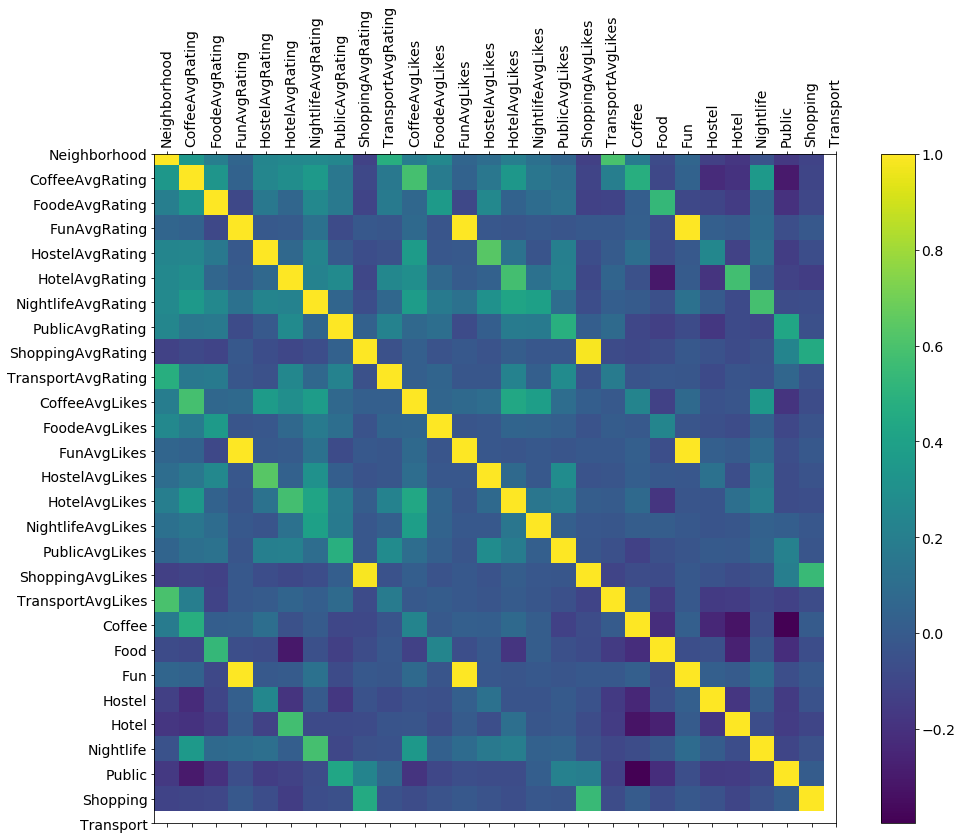

In [53]:
f = plt.figure(figsize=(16, 12))
plt.matshow(mergecountratinglikes.corr(), fignum=f.number)
#plt.matshow(mergecountratinglikes.corr(), vmin=-1, vmax=1)
plt.xticks(range(mergecountratinglikes.shape[1]), mergecountratinglikes.columns, fontsize=14, rotation=90)
plt.yticks(range(mergecountratinglikes.shape[1]), mergecountratinglikes.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
#plt.title('Correlation Matrix\n', fontsize=16);

In [54]:
corr=mergecountratinglikes.corr()
corr

,CoffeeAvgRating,FoodeAvgRating,FunAvgRating,HostelAvgRating,HotelAvgRating,NightlifeAvgRating,PublicAvgRating,ShoppingAvgRating,TransportAvgRating,CoffeeAvgLikes,FoodeAvgLikes,FunAvgLikes,HostelAvgLikes,HotelAvgLikes,NightlifeAvgLikes,PublicAvgLikes,ShoppingAvgLikes,TransportAvgLikes,Coffee,Food,Fun,Hostel,Hotel,Nightlife,Public,Shopping,Transport
CoffeeAvgRating,1.000000,0.341704,0.200256,0.057773,0.240198,0.256542,0.261131,0.245419,-0.121748,0.477190,0.193717,0.256099,0.057773,0.100761,0.202993,0.117780,0.054774,-0.129392,0.596984,0.183443,-0.077861,0.057773,-0.131005,-0.174376,-0.042890,-0.164869,-0.113719
FoodeAvgRating,0.341704,1.000000,0.330979,0.041408,0.242846,0.285771,0.359481,0.158340,-0.093972,0.162144,0.589724,0.182925,0.041408,0.155262,0.345447,0.150233,0.112352,-0.110444,0.200023,0.477738,-0.094997,0.041408,-0.226480,-0.193047,0.360517,-0.294059,-0.105305
FunAvgRating,0.200256,0.330979,1.000000,-0.095448,0.161095,0.061999,0.254216,0.170199,-0.109722,0.180848,0.070125,0.364536,-0.095448,0.256158,0.044354,0.095542,0.129187,-0.124002,-0.114107,0.018609,0.534003,-0.095448,-0.103391,-0.147048,0.078680,-0.198034,-0.100893
HostelAvgRating,0.057773,0.041408,-0.095448,1.000000,-0.004606,0.002250,0.123147,-0.076937,-0.013510,-0.022146,0.078457,-0.027313,1.000000,-0.016736,-0.029311,-0.010209,-0.026968,-0.013172,-0.012947,0.024998,-0.058609,1.000000,0.024333,0.002363,0.091767,-0.058425,-0.012875
HotelAvgRating,0.240198,0.242846,0.161095,-0.004606,1.000000,0.075255,0.233034,-0.005630,-0.067267,-0.050666,0.368744,-0.016844,-0.004606,0.638969,0.131961,-0.033861,0.206396,-0.065582,0.006609,0.108238,-0.074385,-0.004606,0.249498,-0.119550,0.112200,-0.145255,-0.064104
NightlifeAvgRating,0.256542,0.285771,0.061999,0.002250,0.075255,1.000000,0.223812,0.270651,-0.098102,0.248374,0.294875,0.073044,0.002250,0.035596,0.584698,0.125369,0.210480,-0.096048,0.052938,-0.050961,-0.308281,0.002250,-0.185205,0.579150,0.020692,-0.120867,-0.142272
PublicAvgRating,0.261131,0.359481,0.254216,0.123147,0.233034,0.223812,1.000000,0.059995,-0.068094,0.071114,0.372838,0.173619,0.123147,0.307684,0.418622,0.396680,0.100249,-0.066389,0.023022,0.005583,-0.056489,0.123147,-0.001331,-0.079929,0.590357,-0.072839,-0.064893
ShoppingAvgRating,0.245419,0.158340,0.170199,-0.076937,-0.005630,0.270651,0.059995,1.000000,0.036302,0.225012,0.078267,0.108198,-0.076937,0.021638,0.184385,0.171039,0.484094,0.020415,0.085874,-0.098369,-0.130466,-0.076937,-0.170989,-0.080106,-0.097818,0.431711,-0.057543
TransportAvgRating,-0.121748,-0.093972,-0.109722,-0.013510,-0.067267,-0.098102,-0.068094,0.036302,1.000000,-0.047331,0.025432,-0.038328,-0.013510,-0.040118,0.014796,-0.018147,-0.019128,0.983945,-0.079289,-0.094177,-0.073047,-0.013510,-0.045815,-0.074991,-0.051268,0.231661,0.459886
CoffeeAvgLikes,0.477190,0.162144,0.180848,-0.022146,-0.050666,0.248374,0.071114,0.225012,-0.047331,1.000000,0.027989,0.055843,-0.022146,-0.025075,0.223706,0.028898,0.275825,-0.046220,0.183369,-0.031731,-0.017573,-0.022146,-0.081547,-0.033503,-0.046225,0.067050,-0.045090


#### A closer inspection shows that the correlation is not high between the features

<a id='item4'></a>

## Cluster Algorithm

Now that we have prepared the data, we are ready to cluster the neighbourhoods.

Run *k*-means to cluster the neighborhood into 8 clusters.

In [55]:
# set number of clusters
kclusters = 8

london_grouped_clustering = mergecountratinglikes.drop('Neighborhood', 1) # !! #

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(london_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 0, 0, 1, 3, 2, 2, 3, 6, 6], dtype=int32)

In [56]:
kmeans.labels_[0:300].size

105

In [57]:
print(neighborhoods_venues_sorted.shape)
neighborhoods_venues_sorted.head(3)

(105, 10)


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue
0,"Aldersgate,Bassishaw,Cripplegate,Coleman Stree...",Fun,Food,Transport,Shopping,Public,Nightlife,Hotel,Hostel,Coffee
1,"Aldgate,Portsoken,Lime Street,Bishopsgate,Isli...",Food,Coffee,Nightlife,Fun,Transport,Shopping,Public,Hotel,Hostel
2,Barnet,Nightlife,Food,Coffee,Shopping,Transport,Public,Hotel,Hostel,Fun


In [58]:
print(london_datadf1.shape)
london_datadf1.head(3)

(301, 6)


,Postcode,In_use,Parish,Neighborhood,Latitude,Longitude
0,E1,Yes,"City of London, unparished area,Greater London","Bishopsgate,Portsoken,Aldgate,Tower,Tower Haml...",27.962040,86.933700
1,EC1A,Yes,"City of London, unparished area,Greater London","Farringdon Within,Farringdon Without,Cheap,Ald...",51.516355,-0.099135
2,EC1M,Yes,"City of London, unparished area,Greater London","Farringdon Within,Cripplegate,Islington,Camden...",51.521014,-0.106675


In [59]:
print(mergecountratinglikes.shape)
mergecountratinglikes.head(3)

(105, 28)


,Neighborhood,CoffeeAvgRating,FoodeAvgRating,FunAvgRating,HostelAvgRating,HotelAvgRating,NightlifeAvgRating,PublicAvgRating,ShoppingAvgRating,TransportAvgRating,CoffeeAvgLikes,FoodeAvgLikes,FunAvgLikes,HostelAvgLikes,HotelAvgLikes,NightlifeAvgLikes,PublicAvgLikes,ShoppingAvgLikes,TransportAvgLikes,Coffee,Food,Fun,Hostel,Hotel,Nightlife,Public,Shopping,Transport
0,"Aldersgate,Bassishaw,Cripplegate,Coleman Stree...",0.000000,0.439024,0.512195,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000263,0.000789,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.500000,0.500000,0.0,0.0,0.000000,0.0,0.000000,0.0
1,"Aldgate,Portsoken,Lime Street,Bishopsgate,Isli...",0.682927,0.617886,0.390244,0.0,0.0,0.585366,0.0,0.000000,0.0,0.058197,0.004619,0.001579,0.0,0.0,0.018858,0.0,0.000000,0.0,0.285714,0.428571,0.142857,0.0,0.0,0.142857,0.0,0.000000,0.0
2,Barnet,0.463415,0.360976,0.000000,0.0,0.0,0.439024,0.0,0.341463,0.0,0.004122,0.003052,0.000000,0.0,0.0,0.022980,0.0,0.000526,0.0,0.200000,0.333333,0.000000,0.0,0.0,0.333333,0.0,0.133333,0.0


In [60]:
london_datadf2=london_datadf1[['Neighborhood','Latitude','Longitude']]
london_datadf2=london_datadf2.drop_duplicates(subset ="Neighborhood")
print(london_datadf2.shape)
london_datadf2.head(3)

(169, 3)


,Neighborhood,Latitude,Longitude
0,"Bishopsgate,Portsoken,Aldgate,Tower,Tower Haml...",27.962040,86.933700
1,"Farringdon Within,Farringdon Without,Cheap,Ald...",51.516355,-0.099135
2,"Farringdon Within,Cripplegate,Islington,Camden...",51.521014,-0.106675


In [61]:
final_london_data=mergecountratinglikes.merge(london_datadf2, how='left', on='Neighborhood')
print(final_london_data.shape)
final_london_data.head(3)

(105, 30)


,Neighborhood,CoffeeAvgRating,FoodeAvgRating,FunAvgRating,HostelAvgRating,HotelAvgRating,NightlifeAvgRating,PublicAvgRating,ShoppingAvgRating,TransportAvgRating,CoffeeAvgLikes,FoodeAvgLikes,FunAvgLikes,HostelAvgLikes,HotelAvgLikes,NightlifeAvgLikes,PublicAvgLikes,ShoppingAvgLikes,TransportAvgLikes,Coffee,Food,Fun,Hostel,Hotel,Nightlife,Public,Shopping,Transport,Latitude,Longitude
0,"Aldersgate,Bassishaw,Cripplegate,Coleman Stree...",0.000000,0.439024,0.512195,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000263,0.000789,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.500000,0.500000,0.0,0.0,0.000000,0.0,0.000000,0.0,51.517915,-0.091934
1,"Aldgate,Portsoken,Lime Street,Bishopsgate,Isli...",0.682927,0.617886,0.390244,0.0,0.0,0.585366,0.0,0.000000,0.0,0.058197,0.004619,0.001579,0.0,0.0,0.018858,0.0,0.000000,0.0,0.285714,0.428571,0.142857,0.0,0.0,0.142857,0.0,0.000000,0.0,51.513145,-0.078733
2,Barnet,0.463415,0.360976,0.000000,0.0,0.0,0.439024,0.0,0.341463,0.0,0.004122,0.003052,0.000000,0.0,0.0,0.022980,0.0,0.000526,0.0,0.200000,0.333333,0.000000,0.0,0.0,0.333333,0.0,0.133333,0.0,51.542635,-0.098581


Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [62]:
#london_merged = london_datadf1
london_merged = final_london_data

# add clustering labels
london_merged.insert(0, 'Cluster Labels', kmeans.labels_)

london_merged.head(2) # check the last columns!

,Cluster Labels,Neighborhood,CoffeeAvgRating,FoodeAvgRating,FunAvgRating,HostelAvgRating,HotelAvgRating,NightlifeAvgRating,PublicAvgRating,ShoppingAvgRating,TransportAvgRating,CoffeeAvgLikes,FoodeAvgLikes,FunAvgLikes,HostelAvgLikes,HotelAvgLikes,NightlifeAvgLikes,PublicAvgLikes,ShoppingAvgLikes,TransportAvgLikes,Coffee,Food,Fun,Hostel,Hotel,Nightlife,Public,Shopping,Transport,Latitude,Longitude
0,1,"Aldersgate,Bassishaw,Cripplegate,Coleman Stree...",0.000000,0.439024,0.512195,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000263,0.000789,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.500000,0.500000,0.0,0.0,0.000000,0.0,0.0,0.0,51.517915,-0.091934
1,0,"Aldgate,Portsoken,Lime Street,Bishopsgate,Isli...",0.682927,0.617886,0.390244,0.0,0.0,0.585366,0.0,0.0,0.0,0.058197,0.004619,0.001579,0.0,0.0,0.018858,0.0,0.0,0.0,0.285714,0.428571,0.142857,0.0,0.0,0.142857,0.0,0.0,0.0,51.513145,-0.078733


In [63]:
london_merged.shape[1]

31

# Results, Discussions & Recommendations

## You can see most popular venues for coffee, shopping, museums and restaurants below

### Top 5 Shopping locations in London by ratings

#### It is interesting that Waterstones and Hatchards have been rated highly, perhaps there is life left for physical book stores.

In [64]:
londonshopping=london_venues_merged_data[london_venues_merged_data['Highcategory'] == 'Shopping']
toplondonshopping=londonshopping[['Venue','Venue Category','venueRating','Neighborhood','Neighborhood Postcode','Total Likes']].sort_values(by=['venueRating'], ascending=False)
print(toplondonshopping.shape)
toplondonshopping.head(10)

(143, 6)


,Venue,Venue Category,venueRating,Neighborhood,Neighborhood Postcode,Total Likes
1066,Bottle Apostle,Wine Shop,9.3,"Tower Hamlets,Hackney",E9,106.0
1155,Agent Provocateur,Lingerie Store,9.1,City of Westminster,W1F,196.0
1008,Waterstones,Bookstore,9.1,Richmond upon Thames,TW9,60.0
1009,Hatchards,Bookstore,9.1,"City of Westminster,Islington",W1J,656.0
1091,Cass Art,Arts & Crafts Store,9.0,City of Westminster,W1F,149.0
870,Porterford Butchers,Butcher,8.9,"Cordwainer,Bread Street,Vintry,Farringdon With...",EC4M,109.0
1032,Taylor Taylor,Salon / Barbershop,8.9,Newham,E16,125.0
1013,Empório Eldorado,Beer Store,8.9,Croydon,CR2,239.0
1078,Ray Stitch Haberdashery Shop and Café,Hobby Shop,8.8,"Islington,Camden,Hackney",N1,51.0
779,Tower of London Shop,Souvenir Shop,8.8,"Billingsgate,Tower,Bridge,Candlewick,Islington",EC3R,40.0


### Top 5 Museums and Art Galleries in London by ratings

#### It is interesting that popular museums like the British Museum, and Victoria and Albert Museums are not on the list, perhaps data like Ratings and Likes are missing in Foursquare for these venues.

#### We can also conclude that the Science Museum is clearly very popular as it has received a lot of likes in addition to high ratings.

In [65]:
museumcategories = ['Art Gallery','Art Museum','History Museum','Museum','Science Museum','Street Art']
londonfun = london_venues_merged_data[london_venues_merged_data['Highcategory'] == 'Fun']
londonmuseums = londonfun[londonfun['Venue Category'].isin(museumcategories)]
toplondonmuseums=londonmuseums[['Venue','Venue Category','venueRating','Neighborhood','Neighborhood Postcode','Total Likes']].sort_values(by=['venueRating'], ascending=False)
print(toplondonmuseums.shape)
toplondonmuseums.head(10)

(12, 6)


,Venue,Venue Category,venueRating,Neighborhood,Neighborhood Postcode,Total Likes
1142,Science Museum,Science Museum,9.1,"City of Westminster,Kensington and Chelsea",SW7,11401.0
909,Sir John Soane's Museum,History Museum,8.8,"Farringdon Without,Camden,Islington,City of We...",WC2A,886.0
1143,Museum of the History of Medicine,Science Museum,8.3,"City of Westminster,Kensington and Chelsea",SW7,23.0
698,Spitalfields Arts Market,Art Gallery,8.1,Newham,E16,410.0
697,Guildhall Art Gallery,Art Gallery,8.0,"Cheap,Bassishaw,Coleman Street,Bread Street,Co...",EC2V,256.0
908,London Mithraeum Bloomberg SPACE,History Museum,7.9,"Cordwainer,Vintry,Walbrook,Candlewick,Dowgate,...",EC4N,108.0
1144,Science Museum Launch Pad,Science Museum,7.9,"City of Westminster,Kensington and Chelsea",SW7,49.0
1145,Exploring Space,Science Museum,7.6,"City of Westminster,Kensington and Chelsea",SW7,18.0
700,Zaha Hadid Gallery,Art Gallery,7.3,"Islington,Hackney",EC1V,51.0
699,Four Corners,Art Gallery,6.6,"Newham,Hackney",E20,13.0


### Top 10 Restaurants in London by ratings

#### This table flags up some restaurants which are highly which I have not been to.
#### Hawksmoor Spitalfields is clearly a very popular restaurant.
#### The results also show that there is an emerging chain of greek restaurants called GReat.

In [66]:
londonfood = london_venues_merged_data[london_venues_merged_data['Highcategory'] == 'Food']
#londongyms = londonfun[londonfun['Venue Category'].isin(gymcategories)]
toplondonfood=londonfood[['Venue','Venue Category','venueRating','Neighborhood','Neighborhood Postcode','Total Likes']].sort_values(by=['venueRating'], ascending=False)
print(toplondonfood.shape)
toplondonfood.head(10)

(505, 6)


,Venue,Venue Category,venueRating,Neighborhood,Neighborhood Postcode,Total Likes
874,Armazém da Pizza,Pizza Place,9.3,"Croydon,Merton",CR7,740.0
600,Hawksmoor Spitalfields,Steakhouse,9.3,Newham,E16,2506.0
586,GReat,Souvlaki Shop,9.2,"Bishopsgate,Bassishaw,Islington",EC2P,431.0
587,GReat,Souvlaki Shop,9.2,"Lime Street,Islington",EC3P,431.0
588,GReat,Souvlaki Shop,9.2,Islington,EC1P,431.0
589,GReat,Souvlaki Shop,9.2,Islington,EC4P,431.0
0,Pilpel,Falafel Restaurant,9.1,"Farringdon Within,Farringdon Without,Cheap,Ald...",EC1A,389.0
291,Al Boccon Di’vino,Italian Restaurant,9.1,Richmond upon Thames,TW9,286.0
804,Amorino,Ice Cream Shop,9.0,"Kensington and Chelsea,City of Westminster,Lam...",SW3,492.0
584,GAIL's Bakery,Bakery,9.0,Hammersmith and Fulham,SW6,85.0


### Best coffee in London by ratings

#### This section is for those craving a good cup of coffee in London, the venues are well distributed in east and west London, so a good cafe is never too far, even if you might not be aware of it. It's interesting that the coffee chains are not represented on the list.

In [67]:
londoncoffee = london_venues_merged_data[london_venues_merged_data['Highcategory'] == 'Coffee']
#londongyms = londonfun[londonfun['Venue Category'].isin(gymcategories)]
toplondoncoffee=londoncoffee[['Venue','Venue Category','venueRating','Neighborhood','Neighborhood Postcode','Total Likes']].sort_values(by=['venueRating'], ascending=False)
print(toplondoncoffee.shape)
toplondoncoffee.head(10)

(147, 6)


,Venue,Venue Category,venueRating,Neighborhood,Neighborhood Postcode,Total Likes
192,Rosslyn,Coffee Shop,9.5,"Cordwainer,Bread Street,Vintry,Farringdon With...",EC4M,421.0
163,Catalyst Cafe,Coffee Shop,9.3,"Castle Baynard,Farringdon Without,Camden,Islin...",EC1N,482.0
164,Catalyst Cafe,Coffee Shop,9.3,"Farringdon Without,Camden,Islington",WC1V,482.0
183,The Gallery by Taylor St Baristas,Coffee Shop,9.2,"Langbourn,Bridge,Candlewick,Cornhill,Lime Stre...",EC3V,418.0
182,The Gallery by Taylor St Baristas,Coffee Shop,9.2,"Bridge,Billingsgate,Aldgate,Tower,Langbourn,Li...",EC3M,418.0
528,Brickwood Coffee & Bread,Café,9.2,"Lambeth,Wandsworth",SW4,1202.0
181,The Association,Coffee Shop,9.0,"Aldgate,Portsoken,Lime Street,Bishopsgate,Isli...",EC3A,1315.0
165,Prufrock Coffee,Coffee Shop,9.0,"Castle Baynard,Farringdon Without,Camden,Islin...",EC1N,3387.0
206,Campbell & Syme,Coffee Shop,9.0,"Barnet,Haringey",N2,171.0
252,Workshop Coffee Co.,Coffee Shop,9.0,"City of Westminster,Islington",W1U,3762.0


### Top Nightlife venues in London by ratings

#### This section is for those looking for a good night out in London.

In [68]:
#nightcategories = ['Bar','Art Museum','History Museum','Museum','Science Museum','Street Art']
londonnight = london_venues_merged_data[london_venues_merged_data['Highcategory'] == 'Nightlife']
#londonmuseums = londonfun[londonfun['Venue Category'].isin(nightcategories)]
toplondonnightlife=londonnight[['Venue','Venue Category','venueRating','Neighborhood','Neighborhood Postcode','Total Likes']].sort_values(by=['venueRating'], ascending=False)
print(toplondonnightlife.shape)
toplondonnightlife.head(10)

(186, 6)


,Venue,Venue Category,venueRating,Neighborhood,Neighborhood Postcode,Total Likes
735,The Merchant House,Cocktail Bar,9.4,"Cordwainer,Bread Street,Vintry,Farringdon With...",EC4M,462.0
122,The Wigmore,Pub,9.2,"Islington,City of Westminster",W1A,278.0
72,Myddleton Arms,Pub,9.1,Barnet,N12,184.0
298,BrewDog Tower Hill,Beer Bar,9.1,"Billingsgate,Tower,Bridge,Candlewick,Islington",EC3R,587.0
297,BrewDog Tower Hill,Beer Bar,9.1,"Bridge,Billingsgate,Aldgate,Tower,Langbourn,Li...",EC3M,587.0
993,Young Vic,Theater,9.1,Greenwich,SE18,570.0
736,Discount Suit Company,Cocktail Bar,9.0,Waltham Forest,E17,1148.0
995,Her Majesty's Theatre,Theater,9.0,"City of Westminster,Wandsworth",SW1Y,2276.0
73,Smokehouse,Pub,8.9,Barnet,N12,1055.0
57,The Culpeper,Pub,8.8,Waltham Forest,E17,1235.0


## Here's how the neighbourhoods have been clustered

Finally, let's visualize the resulting clusters

In [69]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(london_merged['Latitude'], london_merged['Longitude'], london_merged['Neighborhood'], london_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 5. Examine Clusters

#### Cluster 0 - Red

In [70]:
london_merged.loc[london_merged['Cluster Labels'] == 0, london_merged.columns[[1] + [0] + [3] + list(range(6, london_merged.shape[1]))]]

,Neighborhood,Cluster Labels,FoodeAvgRating,HotelAvgRating,NightlifeAvgRating,PublicAvgRating,ShoppingAvgRating,TransportAvgRating,CoffeeAvgLikes,FoodeAvgLikes,FunAvgLikes,HostelAvgLikes,HotelAvgLikes,NightlifeAvgLikes,PublicAvgLikes,ShoppingAvgLikes,TransportAvgLikes,Coffee,Food,Fun,Hostel,Hotel,Nightlife,Public,Shopping,Transport,Latitude,Longitude
1,"Aldgate,Portsoken,Lime Street,Bishopsgate,Isli...",0,0.617886,0.000000,0.585366,0.000000,0.000000,0.0,0.058197,0.004619,0.001579,0.000000,0.000000,0.018858,0.000000,0.000000,0.0,0.285714,0.428571,0.142857,0.000000,0.000000,0.142857,0.000000,0.000000,0.0,51.513145,-0.078733
2,Barnet,0,0.360976,0.000000,0.439024,0.000000,0.341463,0.0,0.004122,0.003052,0.000000,0.000000,0.000000,0.022980,0.000000,0.000526,0.0,0.200000,0.333333,0.000000,0.000000,0.000000,0.333333,0.000000,0.133333,0.0,51.542635,-0.098581
21,"Camden,Islington",0,0.425474,0.000000,0.626016,0.000000,0.000000,0.0,0.008815,0.005341,0.000000,0.000000,0.000000,0.014034,0.000000,0.000000,0.0,0.250000,0.562500,0.000000,0.000000,0.000000,0.187500,0.000000,0.000000,0.0,51.555700,-0.139260
23,"Castle Baynard,Farringdon Without,Farringdon W...",0,0.439024,0.000000,0.530488,0.000000,0.365854,0.0,0.005504,0.007514,0.000000,0.000000,0.000000,0.014560,0.000000,0.000439,0.0,0.210526,0.473684,0.000000,0.000000,0.000000,0.210526,0.000000,0.105263,0.0,51.515780,-0.110003
24,"Castle Baynard,Farringdon Without,Islington,Ci...",0,0.439024,0.414634,0.341463,0.000000,0.000000,0.0,0.001667,0.001710,0.000000,0.000000,0.021138,0.001930,0.000000,0.000000,0.0,0.200000,0.400000,0.000000,0.000000,0.200000,0.200000,0.000000,0.000000,0.0,51.511695,-0.106418
35,"Cornhill,Broad Street,Walbrook,Bishopsgate,Lim...",0,0.579268,0.000000,0.609756,0.000000,0.000000,0.0,0.000000,0.011172,0.000000,0.000000,0.000000,0.068941,0.000000,0.000000,0.0,0.000000,0.888889,0.000000,0.000000,0.000000,0.111111,0.000000,0.000000,0.0,51.515305,-0.083492
37,Croydon,0,0.273171,0.373984,0.341463,0.073171,0.487805,0.0,0.004210,0.003087,0.000000,0.000000,0.005233,0.004649,0.003070,0.058569,0.0,0.136364,0.454545,0.000000,0.000000,0.136364,0.045455,0.045455,0.181818,0.0,-26.999600,-48.624220
38,"Croydon,Merton",0,0.585366,0.000000,0.482927,0.170732,0.000000,0.0,0.001842,0.015184,0.000000,0.000000,0.000000,0.015788,0.001140,0.000000,0.0,0.062500,0.562500,0.000000,0.000000,0.000000,0.312500,0.062500,0.000000,0.0,-23.205890,-45.897640
44,"Farringdon Within,Cripplegate,Islington,Camden...",0,0.475610,0.000000,0.341463,0.000000,0.000000,0.0,0.001491,0.014516,0.000000,0.000000,0.000000,0.005438,0.000000,0.000000,0.0,0.250000,0.500000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.0,51.521014,-0.106675
50,"Hackney,Haringey,Islington",0,0.646341,0.000000,0.792683,0.000000,0.000000,0.0,0.118367,0.017104,0.000000,0.000000,0.000000,0.020174,0.000000,0.000000,0.0,0.333333,0.333333,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.0,51.529675,-0.083470


#### Cluster 1 - Purple

In [71]:
london_merged.loc[london_merged['Cluster Labels'] == 1, london_merged.columns[[1] + [0] + [3] + list(range(6, london_merged.shape[1]))]]

,Neighborhood,Cluster Labels,FoodeAvgRating,HotelAvgRating,NightlifeAvgRating,PublicAvgRating,ShoppingAvgRating,TransportAvgRating,CoffeeAvgLikes,FoodeAvgLikes,FunAvgLikes,HostelAvgLikes,HotelAvgLikes,NightlifeAvgLikes,PublicAvgLikes,ShoppingAvgLikes,TransportAvgLikes,Coffee,Food,Fun,Hostel,Hotel,Nightlife,Public,Shopping,Transport,Latitude,Longitude
0,"Aldersgate,Bassishaw,Cripplegate,Coleman Stree...",1,0.439024,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000263,0.000789,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.500000,0.0,0.000,0.0,0.000000,0.00,0.0,51.517915,-0.091934
3,"Barnet,Borehamwood",1,0.282927,0.000000,0.000000,0.000000,0.000000,0.000000,0.010438,0.001895,0.012367,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.625000,0.125000,0.0,0.000,0.0,0.000000,0.00,0.0,38.371690,27.178290
12,Brent,1,0.048780,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001228,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000,0.0,0.000000,0.00,0.0,51.558415,-0.276609
13,"Brent,Barnet,Harrow",1,0.219512,0.317073,0.000000,0.000000,0.000000,0.000000,0.000000,0.004210,0.000000,0.0,0.002894,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.0,0.500,0.0,0.000000,0.00,0.0,51.584860,-0.248810
14,"Brent,Hammersmith and Fulham,Ealing,Kensington...",1,0.219512,0.000000,0.097561,0.000000,0.000000,0.000000,0.000000,0.003772,0.000000,0.0,0.000000,0.001754,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.0,0.000,0.5,0.000000,0.00,0.0,51.538380,-0.136485
20,"Camden,Brent,City of Westminster",1,0.394309,0.000000,0.000000,0.000000,0.000000,0.000000,0.002807,0.015905,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.857143,0.000000,0.0,0.000,0.0,0.000000,0.00,0.0,51.541870,-0.197950
27,"City of Westminster,Camden",1,0.634146,0.000000,0.000000,0.463415,0.000000,0.000000,0.000000,0.023375,0.000000,0.0,0.000000,0.000000,0.001403,0.000000,0.000000,0.000000,0.666667,0.000000,0.0,0.000,0.0,0.333333,0.00,0.0,51.517735,-0.133580
28,"City of Westminster,Camden,Brent",1,0.792683,0.000000,0.000000,0.000000,0.000000,0.000000,0.009648,0.014604,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.666667,0.000000,0.0,0.000,0.0,0.000000,0.00,0.0,51.533980,-0.173780
49,"Greenwich,Lewisham",1,0.482927,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012227,0.001140,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.833333,0.166667,0.0,0.000,0.0,0.000000,0.00,0.0,51.502465,-0.100654
52,Hammersmith and Fulham,1,0.504065,0.000000,0.000000,0.000000,0.000000,0.000000,0.001667,0.004444,0.000877,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.600000,0.200000,0.0,0.000,0.0,0.000000,0.00,0.0,51.477720,-0.201450


#### Cluster 2 - Blue

In [72]:
london_merged.loc[london_merged['Cluster Labels'] == 2, london_merged.columns[[1] + [0] + [3] + list(range(6, london_merged.shape[1]))]]

,Neighborhood,Cluster Labels,FoodeAvgRating,HotelAvgRating,NightlifeAvgRating,PublicAvgRating,ShoppingAvgRating,TransportAvgRating,CoffeeAvgLikes,FoodeAvgLikes,FunAvgLikes,HostelAvgLikes,HotelAvgLikes,NightlifeAvgLikes,PublicAvgLikes,ShoppingAvgLikes,TransportAvgLikes,Coffee,Food,Fun,Hostel,Hotel,Nightlife,Public,Shopping,Transport,Latitude,Longitude
5,"Barnet,Haringey",2,0.365854,0.0,0.000000,0.000000,0.195122,0.000000,0.005021,0.001649,0.009078,0.0,0.0,0.000000,0.000000,0.000088,0.000000,0.333333,0.416667,0.166667,0.0,0.0,0.000000,0.000000,0.083333,0.0,51.537615,-0.112693
6,"Bassishaw,Coleman Street,Broad Street,Walbrook...",2,0.449477,0.0,0.345528,0.000000,0.000000,0.000000,0.034690,0.015036,0.001360,0.0,0.0,0.005000,0.000000,0.000000,0.000000,0.117647,0.411765,0.117647,0.0,0.0,0.352941,0.000000,0.000000,0.0,51.516675,-0.089874
11,"Bishopsgate,Islington,Hackney",2,0.585366,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.015525,0.009034,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.500000,0.0,0.0,0.000000,0.000000,0.000000,0.0,51.520305,-0.081081
19,"Camden,Barnet",2,0.500000,0.0,0.000000,0.000000,0.402439,0.000000,0.003684,0.004693,0.000000,0.0,0.0,0.000000,0.000000,0.003903,0.000000,0.333333,0.333333,0.000000,0.0,0.0,0.000000,0.000000,0.333333,0.0,51.555060,-0.173480
25,"Cheap,Bassishaw,Coleman Street,Bread Street,Co...",2,0.434959,0.0,0.373984,0.560976,0.000000,0.000000,0.005000,0.016841,0.022454,0.0,0.0,0.019326,0.015613,0.000000,0.000000,0.083333,0.500000,0.083333,0.0,0.0,0.250000,0.083333,0.000000,0.0,51.516225,-0.091695
29,"City of Westminster,Islington",2,0.451220,0.0,0.585366,0.000000,0.719512,0.000000,0.329971,0.004429,0.001930,0.0,0.0,0.005394,0.000000,0.053197,0.000000,0.083333,0.166667,0.083333,0.0,0.0,0.166667,0.000000,0.500000,0.0,51.514790,-0.148044
30,"City of Westminster,Kensington and Chelsea",2,0.463415,0.0,0.000000,0.000000,0.756098,0.000000,0.051443,0.009122,0.146516,0.0,0.0,0.000000,0.000000,0.009473,0.000000,0.166667,0.166667,0.583333,0.0,0.0,0.000000,0.000000,0.083333,0.0,51.498070,-0.174040
33,"Cordwainer,Bread Street,Vintry,Farringdon With...",2,0.551220,0.0,0.715447,0.000000,0.853659,0.000000,0.026518,0.020934,0.000702,0.0,0.0,0.021869,0.000000,0.009561,0.000000,0.130435,0.652174,0.043478,0.0,0.0,0.130435,0.000000,0.043478,0.0,51.512605,-0.094428
45,"Farringdon Within,Farringdon Without,Cheap,Ald...",2,0.902439,0.0,0.195122,0.384146,0.000000,0.000000,0.000000,0.034120,0.019165,0.0,0.0,0.013244,0.004144,0.000000,0.000000,0.000000,0.125000,0.250000,0.0,0.0,0.125000,0.500000,0.000000,0.0,51.516355,-0.099135
47,"Farringdon Without,Camden,Islington,City of We...",2,0.544715,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.026752,0.074072,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.600000,0.400000,0.0,0.0,0.000000,0.000000,0.000000,0.0,51.516615,-0.116091


#### Cluster 3 - Light Blue

In [73]:
london_merged.loc[london_merged['Cluster Labels'] == 3, london_merged.columns[[1] + [0] + [3] + list(range(6, london_merged.shape[1]))]]

,Neighborhood,Cluster Labels,FoodeAvgRating,HotelAvgRating,NightlifeAvgRating,PublicAvgRating,ShoppingAvgRating,TransportAvgRating,CoffeeAvgLikes,FoodeAvgLikes,FunAvgLikes,HostelAvgLikes,HotelAvgLikes,NightlifeAvgLikes,PublicAvgLikes,ShoppingAvgLikes,TransportAvgLikes,Coffee,Food,Fun,Hostel,Hotel,Nightlife,Public,Shopping,Transport,Latitude,Longitude
4,"Barnet,Camden,Brent",3,0.000000,0.0,0.000000,0.000000,0.268293,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.002894,0.000000,0.000,0.000000,0.0,0.0,0.0,0.000000,0.000000,1.000000,0.000000,51.562370,-0.221310
7,"Bexley,Greenwich",3,0.000000,0.0,0.000000,0.000000,0.292683,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.001403,0.000000,0.000,0.000000,0.0,0.0,0.0,0.000000,0.000000,1.000000,0.000000,51.463130,0.231270
17,"Bromley,Lewisham",3,0.186992,0.0,0.219512,0.146341,0.257036,0.000000,0.003976,0.001974,0.0,0.0,0.0,0.005526,0.006315,0.002847,0.000000,0.125,0.250000,0.0,0.0,0.0,0.041667,0.041667,0.541667,0.000000,51.404240,0.015425
58,"Harrow,Ealing",3,0.000000,0.0,0.000000,0.000000,0.073171,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000526,0.000000,0.000,0.000000,0.0,0.0,0.0,0.000000,0.000000,1.000000,0.000000,51.570765,-0.352311
60,"Hillingdon,Hounslow",3,0.231707,0.0,0.195122,0.000000,0.324042,0.658537,0.000000,0.018770,0.0,0.0,0.0,0.029383,0.000000,0.002481,0.034822,0.000,0.181818,0.0,0.0,0.0,0.090909,0.000000,0.636364,0.090909,51.470940,-0.449538
96,"Southwark,Lewisham",3,0.390244,0.0,0.000000,0.000000,0.463415,0.000000,0.000000,0.001579,0.0,0.0,0.0,0.000000,0.000000,0.003508,0.000000,0.000,0.500000,0.0,0.0,0.0,0.000000,0.000000,0.500000,0.000000,51.489345,-0.071153
102,"Waltham Forest,Newham",3,0.146341,0.0,0.024390,0.000000,0.146341,0.000000,0.000000,0.000044,0.0,0.0,0.0,0.004035,0.000000,0.000439,0.000000,0.000,0.400000,0.0,0.0,0.0,0.200000,0.000000,0.400000,0.000000,51.546680,0.025580


#### Cluster 4 - Light Blue

In [74]:
london_merged.loc[london_merged['Cluster Labels'] == 4, london_merged.columns[[1] + [0] + [3] + list(range(6, london_merged.shape[1]))]]

,Neighborhood,Cluster Labels,FoodeAvgRating,HotelAvgRating,NightlifeAvgRating,PublicAvgRating,ShoppingAvgRating,TransportAvgRating,CoffeeAvgLikes,FoodeAvgLikes,FunAvgLikes,HostelAvgLikes,HotelAvgLikes,NightlifeAvgLikes,PublicAvgLikes,ShoppingAvgLikes,TransportAvgLikes,Coffee,Food,Fun,Hostel,Hotel,Nightlife,Public,Shopping,Transport,Latitude,Longitude
16,"Bromley,Greenwich",4,0.000000,0.0,0.390244,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000965,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,1.000000,0.0,0.000000,0.0,51.410190,0.060795
18,Camden,4,0.000000,0.0,0.390244,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.005000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,1.000000,0.0,0.000000,0.0,43.491833,-80.228255
39,"Dowgate,Candlewick,Vintry,Cordwainer,Bridge,Is...",4,0.591463,0.0,0.595122,0.0,0.000000,0.0,0.000000,0.017323,0.006754,0.0,0.0,0.002526,0.0,0.000000,0.0,0.0,0.400000,0.100000,0.0,0.0,0.500000,0.0,0.000000,0.0,51.510225,-0.089155
40,Enfield,4,0.000000,0.0,0.634146,0.0,0.000000,0.0,0.000263,0.000000,0.000000,0.0,0.0,0.002368,0.0,0.000000,0.0,0.5,0.000000,0.000000,0.0,0.0,0.500000,0.0,0.000000,0.0,51.644715,-0.062664
41,"Enfield,Barnet",4,0.536585,0.0,0.682927,0.0,0.000000,0.0,0.000000,0.032278,0.000000,0.0,0.0,0.037058,0.0,0.000000,0.0,0.0,0.333333,0.000000,0.0,0.0,0.666667,0.0,0.000000,0.0,51.650000,-0.200000
43,"Enfield,Haringey",4,0.000000,0.0,0.731707,0.0,0.829268,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.050171,0.0,0.014122,0.0,0.0,0.000000,0.000000,0.0,0.0,0.500000,0.0,0.500000,0.0,51.541310,-0.088840
51,"Hackney,Tower Hamlets,Islington",4,0.200000,0.0,0.550523,0.0,0.219512,0.0,0.000000,0.000965,0.037307,0.0,0.0,0.021164,0.0,0.000789,0.0,0.0,0.312500,0.187500,0.0,0.0,0.437500,0.0,0.062500,0.0,51.545050,-0.055320
66,"Islington,City of Westminster",4,0.000000,0.0,0.926829,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.024384,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,1.000000,0.0,0.000000,0.0,51.518200,-0.143917
77,"Lambeth,Wandsworth,Croydon,Merton",4,0.000000,0.0,0.780488,0.0,0.268293,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.009297,0.0,0.003596,0.0,0.0,0.000000,0.000000,0.0,0.0,0.500000,0.0,0.500000,0.0,51.418700,-0.127530
81,"Lewisham,Greenwich,Bromley",4,0.524390,0.0,0.546341,0.0,0.365854,0.0,0.000000,0.015437,0.002719,0.0,0.0,0.040523,0.0,0.000965,0.0,0.0,0.461538,0.076923,0.0,0.0,0.384615,0.0,0.076923,0.0,51.502270,-0.076460


#### Cluster 5 - Light Green

In [75]:
london_merged.loc[london_merged['Cluster Labels'] == 5, london_merged.columns[[1] + [0] + [3] + list(range(6, london_merged.shape[1]))]]

,Neighborhood,Cluster Labels,FoodeAvgRating,HotelAvgRating,NightlifeAvgRating,PublicAvgRating,ShoppingAvgRating,TransportAvgRating,CoffeeAvgLikes,FoodeAvgLikes,FunAvgLikes,HostelAvgLikes,HotelAvgLikes,NightlifeAvgLikes,PublicAvgLikes,ShoppingAvgLikes,TransportAvgLikes,Coffee,Food,Fun,Hostel,Hotel,Nightlife,Public,Shopping,Transport,Latitude,Longitude
36,"Cripplegate,Coleman Street,Islington,City of L...",5,0.0,0.000000,0.0,0.0,0.0,0.0,0.029647,0.0,0.005921,0.0,0.000000,0.0,0.0,0.0,0.0,0.333333,0.0,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,51.522690,-0.095445
42,"Enfield,Barnet,Haringey",5,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.002193,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,51.542690,-0.109138
57,"Haringey,Islington,Hackney",5,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.004912,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,51.534870,-0.082352
80,"Lewisham,Greenwich",5,0.0,0.268293,0.0,0.0,0.0,0.0,0.000000,0.0,0.003245,0.0,0.007455,0.0,0.0,0.0,0.0,0.000000,0.0,0.500000,0.0,0.5,0.0,0.0,0.0,0.0,51.498755,-0.078312


#### Cluster 6 - Light Amber

In [76]:
london_merged.loc[london_merged['Cluster Labels'] == 6, london_merged.columns[[1] + [0] + [3] + list(range(6, london_merged.shape[1]))]]

,Neighborhood,Cluster Labels,FoodeAvgRating,HotelAvgRating,NightlifeAvgRating,PublicAvgRating,ShoppingAvgRating,TransportAvgRating,CoffeeAvgLikes,FoodeAvgLikes,FunAvgLikes,HostelAvgLikes,HotelAvgLikes,NightlifeAvgLikes,PublicAvgLikes,ShoppingAvgLikes,TransportAvgLikes,Coffee,Food,Fun,Hostel,Hotel,Nightlife,Public,Shopping,Transport,Latitude,Longitude
8,"Billingsgate,Tower,Bridge,Candlewick,Islington",6,0.398852,0.743902,0.482927,0.000000,0.414634,0.0,0.028287,0.022366,0.001053,0.0,0.009736,0.038207,0.000000,0.003026,0.0,0.068966,0.586207,0.034483,0.0,0.068966,0.172414,0.000000,0.068966,0.0,51.509130,-0.079927
9,"Bishopsgate,Bassishaw,Islington",6,0.579268,0.829268,0.487805,0.000000,0.000000,0.0,0.009619,0.054052,0.000000,0.0,0.006491,0.029427,0.000000,0.000000,0.0,0.214286,0.571429,0.000000,0.0,0.071429,0.142857,0.000000,0.000000,0.0,51.524300,-0.111400
10,"Bishopsgate,Broad Street,Coleman Street,Cornhi...",6,0.554878,0.804878,0.000000,0.000000,0.487805,0.0,0.006754,0.007624,0.002017,0.0,0.057977,0.000000,0.000000,0.002105,0.0,0.058824,0.705882,0.058824,0.0,0.058824,0.000000,0.000000,0.117647,0.0,51.516950,-0.083334
32,"City of Westminster,Wandsworth,Kensington and ...",6,0.650407,0.829268,0.560976,0.634146,0.000000,0.0,0.000000,0.008771,0.005438,0.0,0.040084,0.001316,0.010525,0.000000,0.0,0.000000,0.428571,0.142857,0.0,0.142857,0.142857,0.142857,0.000000,0.0,51.497825,-0.146532
34,"Cordwainer,Vintry,Walbrook,Candlewick,Dowgate,...",6,0.598670,0.975610,0.000000,0.658537,0.000000,0.0,0.011841,0.019017,0.005994,0.0,0.096658,0.000000,0.002894,0.000000,0.0,0.058824,0.647059,0.176471,0.0,0.058824,0.000000,0.058824,0.000000,0.0,51.512535,-0.090942
63,Islington,6,0.579268,0.829268,0.487805,0.000000,0.000000,0.0,0.009619,0.054052,0.000000,0.0,0.006491,0.029427,0.000000,0.000000,0.0,0.214286,0.571429,0.000000,0.0,0.071429,0.142857,0.000000,0.000000,0.0,51.524300,-0.111400
64,"Islington,Camden",6,0.585366,0.829268,0.593496,0.000000,0.570732,0.0,0.007017,0.010863,0.000000,0.0,0.006491,0.068327,0.000000,0.008017,0.0,0.083333,0.541667,0.000000,0.0,0.041667,0.125000,0.000000,0.208333,0.0,51.522350,-0.110058
70,"Kensington and Chelsea,City of Westminster,Wan...",6,0.378049,0.780488,0.000000,0.658537,0.000000,0.0,0.002807,0.014648,0.005087,0.0,0.010350,0.000000,0.003772,0.000000,0.0,0.166667,0.333333,0.166667,0.0,0.166667,0.000000,0.166667,0.000000,0.0,51.500645,-0.150957
84,"Lime Street,Islington",6,0.579268,0.829268,0.487805,0.000000,0.000000,0.0,0.009619,0.054052,0.000000,0.0,0.006491,0.029427,0.000000,0.000000,0.0,0.214286,0.571429,0.000000,0.0,0.071429,0.142857,0.000000,0.000000,0.0,51.524300,-0.111400
89,"Portsoken,Tower,Aldgate,Tower Hamlets,City of ...",6,0.337979,0.601626,0.225610,0.000000,0.000000,0.0,0.015086,0.003145,0.003859,0.0,0.012835,0.002215,0.000000,0.000000,0.0,0.058824,0.411765,0.117647,0.0,0.176471,0.235294,0.000000,0.000000,0.0,51.512587,-0.075560


#### Cluster 7 - Amber

Seems to be inclining towards food. Tells us that restaurants can be more generally found in west London.

In [77]:
london_merged.loc[london_merged['Cluster Labels'] == 7, london_merged.columns[[1] + [0] + [3] + list(range(6, london_merged.shape[1]))]]

,Neighborhood,Cluster Labels,FoodeAvgRating,HotelAvgRating,NightlifeAvgRating,PublicAvgRating,ShoppingAvgRating,TransportAvgRating,CoffeeAvgLikes,FoodeAvgLikes,FunAvgLikes,HostelAvgLikes,HotelAvgLikes,NightlifeAvgLikes,PublicAvgLikes,ShoppingAvgLikes,TransportAvgLikes,Coffee,Food,Fun,Hostel,Hotel,Nightlife,Public,Shopping,Transport,Latitude,Longitude
15,"Bridge,Billingsgate,Aldgate,Tower,Langbourn,Li...",7,0.678862,0.365854,0.699187,0.926829,0.000000,0.0,0.020086,0.017542,0.201210,0.0,0.003859,0.049002,0.060521,0.000000,0.0,0.125000,0.375000,0.187500,0.0,0.062500,0.187500,0.062500,0.000000,0.0,51.510555,-0.082258
22,"Castle Baynard,Farringdon Without,Camden,Islin...",7,0.615854,0.000000,0.780488,0.902439,0.000000,0.0,0.138913,0.010876,0.003070,0.0,0.000000,0.171125,0.079818,0.000000,0.0,0.266667,0.533333,0.066667,0.0,0.000000,0.066667,0.066667,0.000000,0.0,51.520029,-0.110511
26,City of Westminster,7,0.695122,0.804878,0.780488,0.463415,0.780488,0.0,0.000000,0.031269,0.001930,0.0,0.074730,0.084145,0.001403,0.119441,0.0,0.000000,0.166667,0.083333,0.0,0.083333,0.250000,0.083333,0.333333,0.0,51.520132,-0.145370
31,"City of Westminster,Wandsworth",7,0.582843,0.738676,0.569845,0.658537,0.639024,0.0,0.013771,0.025285,0.002281,0.0,0.023695,0.030141,0.009122,0.003631,0.0,0.078125,0.453125,0.062500,0.0,0.109375,0.171875,0.046875,0.078125,0.0,51.504456,-0.140785
46,"Farringdon Without,Camden,Islington",7,0.417073,0.000000,0.731707,0.829268,0.329268,0.0,0.026284,0.009078,0.000000,0.0,0.000000,0.074116,0.006228,0.004561,0.0,0.176471,0.588235,0.000000,0.0,0.000000,0.058824,0.058824,0.117647,0.0,51.518660,-0.112101
65,"Islington,Camden,Hackney",7,0.682927,0.000000,0.674797,0.695122,0.692683,0.0,0.022630,0.029383,0.003421,0.0,0.000000,0.028038,0.005043,0.008894,0.0,0.071429,0.071429,0.142857,0.0,0.000000,0.214286,0.142857,0.357143,0.0,51.537920,-0.099830
86,Newham,7,0.681301,0.000000,0.604878,0.926829,0.658537,0.0,0.010131,0.060714,0.009017,0.0,0.000000,0.038453,0.714850,0.008095,0.0,0.057143,0.428571,0.142857,0.0,0.000000,0.142857,0.028571,0.200000,0.0,51.517825,-0.048490
91,Richmond upon Thames,7,0.585366,0.000000,0.543554,0.414634,0.456446,0.0,0.007894,0.007982,0.019867,0.0,0.000000,0.007493,0.001316,0.004636,0.0,0.161290,0.290323,0.064516,0.0,0.000000,0.225806,0.032258,0.225806,0.0,51.464820,-0.265910


## Conclusion

Nightlife can be found mostly in Cluster 4 (Light Blue) locations, near to central London. There are several nightlife venues in south London, in the Southwark/ London Bridge area. It corroborates with the top 10 nightlife venues above.

There are some fun venues (Cluster 5) found mostly in central London.

Most hotels can be found in west London, in Cluster 1 (purple) locations.

Food venues (Cluster 0 Red) can be found more towards east London.

The neighbourhoods (Cluster 7 Amber) with the better restaurants tend to be in west London.

There are neighbourhoods in East London (Cluster 6 Light Amber) which have a good combination of restaurants, nightlife and cafes.